# 附录 A： MCMC 随机性推断

<style>p{text-indent:2em;2}</style>

【原文】 [MCMC sampling for dummies — While My MCMC Gently Samples (twiecki.io)](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)

当谈论概率编程和贝叶斯统计时，通常会掩饰统计推断实际执行的细节，本质上将其视为黑匣子。概率编程好处在于“不必为构建模型而理解推断的工作原理”，但了解其原理肯定会有所帮助。

当我向新手介绍一个贝叶斯模型时，他虽然没有接受过贝叶斯统计方面的培训，但通常渴望理解推断原理。而我之前的回答往往是：“ MCMC 通过构造一个以目标后验分布为平衡分布的可逆马尔可夫链，通过从后验分布中产生样本来做预测等后续任务。” 这句话没错，但似乎没有用。这很恼火，因为从来没有人告诉你概念背后的直观感觉或者动机，通常只是给你一些可怕的数学知识。我不得不花无数小时用头撞墙，直到顿悟时刻的到来。通常情况下，一旦我理解了其意思，事情就看起来不那么复杂了。[这篇博客文章](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) 试图解释 `MCMC` 采样背后的动机。

下面使用代码示例，而不是公式或数学语言，开始建立直观感觉。

## 1 问题及其非直观的解释

首先看贝叶斯公式：

```{math}
P(\theta|x) = \frac{P(x|\theta) P(\theta)} {P(x)}
```

在给定数据情况下，能够得到模型参数 $\theta$ 的概率分布。为计算它，将先验 $P(\theta)$ 和似然 $P(x|\theta)$  相乘得到分子项。通常分子项非常简单，但仔细观察分母项 $P(x)$ （也称为证据或边缘似然），会发现它是对所有可能的参数值进行积分计算而来。

```{math}
P ( x ) = \int _ { \theta } P ( x , \theta ) d \theta
```

这就是贝叶斯公式的关键难点：尽管公式看起来足够简单，但很难以封闭方式计算后验结果。

如果我们解决不了什么问题，可以试着去近似它。例如，如果能从后验分布中抽取样本，就可以用蒙特卡罗方法进行后续任务的近似计算。但新的问题出现了，要直接从后验分布中抽取样本，不仅要求解贝叶斯公式，而且还要求出它的逆函数，这就更难了。

能否构建一个可遍历的可逆马尔可夫链，使其均衡分布与后验分布相匹配呢？ 这听起来很疯狂，因为如果你无法计算后验，不能从中取样，那么构建这样的马尔可夫链肯定会更加困难。但令人惊讶是，这个想法非常容易实现，并存在一类通用算法来支撑，被称为[马尔可夫链蒙特卡罗](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)，即构造马尔可夫链进行蒙特卡罗逼近。

## 2 问题设置

首先，让导入 python 模块：

In [1]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm 
sns.set_style('white') 
sns.set_context('talk') 
np.random.seed(123) 

先生成一些实验数据，以零为中心的正态分布上的 20 个点。我们的目标是估计平均值 $\mu$ 的后验。

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


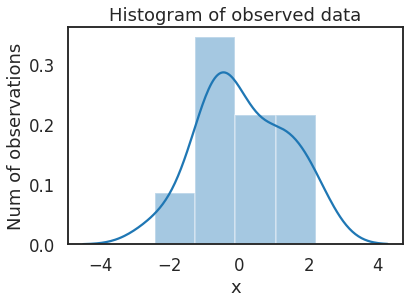

In [2]:
data = np.random.randn(20) 
ax = plt.subplot() 
sns.distplot(data, kde=True, ax=ax) 
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='Num of observations')

接下来定义模型。在这个简单例子中，假设总体和样本呈正态分布（即模型的似然是正态分布）。正态分布有两个参数：均值（ $\mu$ ）和标准差（ $\sigma$ ）。为简单起见，假设已知 $\sigma=1$，想要推断 $\mu$ 的后验。根据贝叶斯原理，对于每个想要推断的参数，必须选择一个先验。为简单起见，仍然假设参数 $\mu$ 呈正态分布，且均值 $\mu_\mu = 0$ ，标准差 $\mu_\sigma = 1$ ，即将标准正态分布作为 $\mu$ 的先验分布。从统计学角度，模型是：

```{math}
\begin{aligned}
先验：\mu & \sim \operatorname{Normal}(0,1) \\
似然：x \mid \mu & \sim \operatorname{Normal}(x ; \mu, 1) 
\end{aligned}
```

该模型较为简单，实际上可以获得后验的解析解。因为对于已知标准差的正态似然分布，$\mu$ 的先验与后验是共轭的（高斯分布是高斯似然的共轭先验），可以较为容易地计算后验。有关这一点的数学推导，请参见（[此处](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM)）。

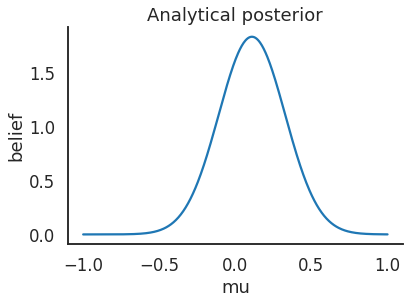

In [3]:
# Analytical posterior of Guassian
def calc_posterior_analytical(data, x, mu_0, sigma_0): 
   sigma = 1. 
   n = len(data) 
   mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2) 
   sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1 
   
   return norm(mu_post, np.sqrt(sigma_post)).pdf(x) 
   
ax = plt.subplot() 
x = np.linspace(-1, 1, 500) 

posterior_analytical = calc_posterior_analytical(data, x, 0., 1.) 

ax.plot(x, posterior_analytical) 
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior'); 
sns.despine() 

这显示了我们的兴趣量，即在考虑到先验信息并看到数据后，参数值 $\mu$ 的概率。但需要清楚，当先验假设并非共轭时，很难获得如此简单的解析解。

## 3 MCMC 采样的代码说明

现在来理解采样逻辑。首先找到起始参数位置（可以随机选择），任意固定为：

In [4]:
mu_current = 1
proposal_width = 1

### （1）位置提议

先建议从该位置移动到其他位置（建议的方法可以简单也可以复杂，可以跳跃也可以平稳，当这种移动是平稳时，通常正是 MCMC 的马尔可夫部分）。著名的`Metropolis 采样器`采用的就是比较简单的办法，它从以当前 `mu_current` 为中心的正态分布中抽取样本（注意：此处是 `Metropolis 准则`的设计要求，并非源于模型的高斯假设），该值具有一定标准差（`proposal_width`），该标准差将决定建议移动的距离（这里使用了 `scipy.stats.norm` 计算距离）：

In [5]:
mu_proposal = norm(mu_current, proposal_width).rvs()

### （2）位置评估

接下来，将评估这是否是一个好位置。如果所建议的 `mu_proposal` 得到的正态分布比原来的 `mu_current` 更能够解释数据，则肯定想去建议位置。“更好地解释数据”是什么意思？ 我们按照当前平均值（`mu_current`）和建议平均值（`mu_proposal`）以及已知标准差 `sigma = 1` 分别计算似然（通过 `scipy.stats.Normal(µ，sigma).pdf(Data)` 计算每个数据点的概率，然后将各数据点的概率相乘），而后进行量化拟合。

In [6]:
# 计算似然 Likelihood
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# 计算先验 Prior        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# 计算分子项 Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

NameError: name 'mu_prior_mu' is not defined

到目前为止，我们基本上可以设计一个爬山算法。该算法从一个随机值开始，只按照建议的随机方向移动。按照最大似然目标，应当只有在建议参数值（ `mu_proposal`）的分子项高于当前值（`mu_current`）的分子项时才接受移动，并最终逼近 $\mu = 0$。 但由于初始值是随机选择的，为了获得完整后验，也需要接受建议值小于当前值的情况，此时可以定义两个分子项的比值作为接受率，用其确定接受移动的概率，接受率越大，则接受移动的概率越高。

In [ ]:
p_accept = p_proposal / p_current

以上 `p_accept` 即为接受率。如果 `p_accept > 1` ，则肯定接受移动；如果 `p_accept < 1`，则以 `p_accept` 为概率决定是否接受移动。例如：当 `p_accept = 0.5` 时，即建议的参数值解释数据的能力只有当前值一半时，有 50% 的机会选择接受移动。

In [ ]:
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

这个简单程序为我们提供了后验的样本。

## 4 为什么会起作用？

请注意，接受率 `p_accept` 是整个事情得以解决的主要原因。下式为 `p_accept` 的直观解释，可以看出，接受率实质上是建议值的后验与当前值后验的比值：

```{math}
\frac{\frac{P(x \mid \mu) P(\mu)}{P(x)}}{\frac{P(x \mid \mu 0) P(\mu 0}{P(x)}}=\frac{P(x \mid \mu) P(\mu)}{P\left(x \mid \mu_{0}\right) P\left(\mu_{0}\right)}
```

将建议参数的后验除以当前参数的后验，证据 $P(x)$ 被抵消了。可以直觉地认为，是在用一个位置的全部后验除以另一个位置的全部后验。这样，我们访问后验概率较高的区域比后验概率较低的区域就要频繁得多。

将上述过程放在一起：

In [ ]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.): 
   mu_current = mu_init 
   posterior = [mu_current] 

   for i in range(samples): 
       # 提出一个建议值 suggest new position 
       mu_proposal = norm(mu_current, proposal_width).rvs() 

       # 计算当前值和建议值的似然 Compute likelihood by multiplying probabilities of each data point 
       likelihood_current = norm(mu_current, 1).pdf(data).prod() 
       likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() 
        
       # 计算当前值和建议值的先验概率 Compute prior probability of current and proposed mu         
       prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) 
       prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) 
    
       # 计算后验的分子项
       p_current = likelihood_current * prior_current 
       p_proposal = likelihood_proposal * prior_proposal 
        
       # 获得接受概率 Accept proposal? 
       p_accept = p_proposal / p_current 
        
       # Usually would include prior probability, which we neglect here for simplicity 
       accept = np.random.rand() < p_accept 
        
       if plot: 
           plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i) 
        
       if accept: 
           # Update position 
           mu_current = mu_proposal 
        
       posterior.append(mu_current) 
        
   return np.array(posterior) 

# Function to display 
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i): 
   from copy import copy 
   trace = copy(trace) 
   fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4)) 
   fig.suptitle('Iteration %i' % (i + 1)) 
   x = np.linspace(-3, 3, 5000) 
   color = 'g' if accepted else 'r' 
        
   # 先验Plot prior 
   prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) 
   prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) 

   prior = norm(mu_prior_mu, mu_prior_sd).pdf(x) 
   ax1.plot(x, prior) 
   ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b') 
   ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color) 
   ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle="->", lw=2.)) 
   ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal)) 
    
   # 似然 Likelihood 
   likelihood_current = norm(mu_current, 1).pdf(data).prod() 
   likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() 

   y = norm(loc=mu_proposal, scale=1).pdf(x) 
   sns.distplot(data, kde=False, norm_hist=True, ax=ax2) 
   ax2.plot(x, y, color=color) 
   ax2.axvline(mu_current, color= 'b' , linestyle='--' , label= 'mu_current' ) 
   ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal') 
   #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected')) 
   ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle="->", lw=2.)) 
   ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal)) 
    
   # 后验 Posterior 
   posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd) 
   ax3.plot(x, posterior_analytical) 
   posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd) 
   posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd) 
   
   ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b') 
   ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color) 
   ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),arrowprops=dict(arrowstyle="->", lw=2.)) 
   #ax3.set(title=r'prior x likelihood $\propto$ posterior') 
   ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal)) 
    
   if accepted: 
       trace.append(mu_proposal) 
   else: 
       trace.append(mu_current) 

   ax4.plot(trace) 
   ax4.set(xlabel='iteration', ylabel='mu', title='trace') 
   plt.tight_layout() 
   #plt.legend() 

## 5 可视化 MCMC

为了使采样可视化，我们将为计算出的一些量创建曲线图。下面图中的每一行都是 `Metropolis 采样器`的一次迭代。

第一列是先验分布，即看到数据之前对于 $\mu$ 的信念。可以看到分布是静态的，我们只是插入了 $\mu$ 的建议值。蓝色竖线表示当前 $\mu$ ，而红色或绿色竖线表示建议 $\mu$，分别被拒绝或接受。

第二列是似然，用来评估模型对数据的解释能力。可以看到，似然随建议值变化而变化。蓝色直方图是数据，绿色或红色实线是当前值和建议值的似然。直观地说，似然与数据之间的重叠越多，模型对数据的解释就越好，由此产生的概率也就越高。相同颜色的虚线是建议值的 $\mu$ ，而蓝色虚线是当前值的 $\mu$ 。

第三列是后验分布。这里显示的是归一化后验，但正如上面所提到的，可以将 “先验 x 似然” 得到非归一化的后验值；然后两者相除得到接受率 `p_accept` 。

第四列是迹（即生成的后验样本），存储了所有建议值，不管它是被接受还是被拒绝。

我们经常根据后验密度移动到相对更可能的 $\mu$ 值，只是有时移动到相对不太可能的值，就像在第 14 次迭代中看到的那样。

In [ ]:
np.random.seed(123) 
sampler(data, samples=20, mu_init=-1., plot=True)

MCMC 的神奇之处在于，只要做足够长的时间，就会产生来自模型后验分布的样本。有一个严格的数学证明可以保证这一点，但在这里不会详细说明。为了解这会产生什么，让我们抽取大量样本（建议值）并绘制其曲线图。

In [ ]:
posterior = sampler(data, samples=15000, mu_init=1.) 
fig, ax = plt.subplots() 
ax.plot(posterior) 
_ = ax.set(xlabel='sample', ylabel='mu'); 

代码抽取的所有样本（建议值）构成迹。**要得到近似的后验，只需计算迹的直方图即可**。需要注意的是，尽管后验直方图看起来与上面为拟合模型而生成的采样数据直方图非常像，但其实两者应当是完全分离的。下图表示了我们对 $\mu$ 的信念，本例中后验碰巧也是正态分布，因此与似然和先验相似，但实际上对于不同模型，后验可能具有与似然或先验完全不同的形状。

In [ ]:
ax = plt.subplot() 
sns.distplot(posterior[500:], ax=ax, label='estimated posterior') 
x = np.linspace(-.5, .5, 500) 
post = calc_posterior_analytical(data, x, 0, 1) 
ax.plot(x, post, 'g', label='analytic posterior') 
_ = ax.set(xlabel='mu', ylabel='belief'); 
ax.legend();

如您所见，通过上面过程，我们得到了与解析解非常吻合的后验分布样本。

## 6 建议宽度

上面代码将建议宽度（步长） `proposal_width` 设置为 0.5。事实证明，这是一个不错的值。一般来说，不希望宽度太窄，因为宽度越窄就需要越长时间来探索整个参数空间，从而造成采样效率会下降，并且出现随机游走的现象：

In [ ]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01) 
fig, ax = plt.subplots() 
ax.plot(posterior_small)
_ = ax.set(xlabel='sample', ylabel='mu')

但你也不希望它太大，以至于永远不会接受移动：

In [ ]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.) 
fig, ax = plt.subplots() 
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu')
_ = ax.set(xlabel='sample', ylabel='mu')

注意，不管建议宽度如何选择，数学证明保证了我们仍在从目标后验中采样，只是效率较低：

In [ ]:
sns.distplot(posterior_small[1000:], label='Small step size') 
sns.distplot(posterior_large[1000:], label='Large step size')
_ = plt.legend()

更多的样本最终会看起来像真实后验，根据蒙特卡洛方法的假设，样本之间应彼此独立，但显然本例无法做到这一点。因此，可以采用自相关性来量化评估采样器的效果，即分析第 $i$ 个样本与第 $i-1$ 、$i-2$ 个样本的相关性如何：

In [ ]:
from pymc3.stats import autocorr 
lags = np.arange(1, 100) 
fig, ax = plt.subplots() 

ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size') 
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size') 
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size') 

ax.legend(loc=0) 
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

显然，我们希望有一种智能方法来自动计算出正确的宽度（步长）。一种常见方法是保持接受率（如：50%）不变，而不断调整建议宽度。

## 7 扩展到更复杂的模型

我们还可以将标准差视为一个参数，命名为 $\sigma$ ，然后对其执行相同的步骤。此时需要为 $\mu$ 和 $\sigma$ 两个随机变量在二维参数空间中生成建议值，其算法逻辑几乎与单变量时相同。当然我们也可以将高斯分布换成其他完全不同的分布（如：二项分布），并从中抽取数据，但依然可以使用相同算法逻辑，并得到正确后验。这是概率编程的巨大好处：**只需定义想要的模型，让 MCMC 负责推断**。

例如：下面的模型可以很容易地用 PyMC3 编写。我们继续使用 `Metropolis 采样器`（自动调整建议宽度），并得到了相同的结果。有关更多信息以及更复杂的示例，请参阅 PyMC3 文档 （http://pymc-devs.github.io/pymc3/getting_started/）。

In [ ]:
import pymc3 as pm 
with pm.Model(): 
   mu = pm.Normal('mu', 0, 1) 
   sigma = 1. 
   returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data) 
    
   step = pm.Metropolis() 
   trace = pm.sample(15000, step) 
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler')
sns.distplot(posterior[500:], label='Hand-written sampler')
plt.legend()

## 8 总结

有关 MCMC 的细节非常重要，但还有很多其他帖子介绍它。因此，本文重点在于直观地介绍 `MCMC` 和 `Metropolis 采样器`的核心思想。希望读者已经形成了直观感觉。其他更先进和复杂的 MCMC 算法，如：汉密尔顿蒙特卡罗方法（HMC）、NUTS等，算法逻辑与此非常相似，只是步长选择和建议值生成的方法聪明得多。

本文有 Jupyter Notebook 版本，可以从 [此处](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb)  下载。